In [ ]:
# Google Colab setup for Kaggle API

from google.colab import files

!pip install -q kaggle

files.upload()

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# 1. Download the full zip (it's big, but reliable)
!kaggle datasets download -d mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot

# 2. Extract ONLY the DNN-EdgeIIoT-dataset.csv file
# The -j flag flattens the directory structure so it drops right into your current folder
!unzip -j edgeiiotset-cyber-security-dataset-of-iot-iiot.zip "*DNN-EdgeIIoT-dataset.csv" "*ML-EdgeIIoT-dataset.csv" -d .

# 3. Verify it's there
!ls -lh DNN-EdgeIIoT-dataset.csv

^C
Archive:  edgeiiotset-cyber-security-dataset-of-iot-iiot.zip
replace ./DNN-EdgeIIoT-dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import pandas as pd

import numpy as np

df_ml = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)
# df_dl = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False)

# Standard Preprocessing
Prepprocess the data in accordance to steps outlined in EdgeIIoT paper

In [3]:
import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import re


def preprocess(df, output_path=None):
    df = df.copy()
    
    # Drop columns
    drop_columns = [
        "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4", 
        "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp",
        "http.request.uri.query", "tcp.options", "tcp.payload", "tcp.srcport",
        "tcp.dstport", "udp.port", "mqtt.msg"
    ]
    df.drop(drop_columns, axis=1, inplace=True, errors='ignore')
    
    # Drop NaN and duplicates
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df, random_state=42)
    
    # Encode categorical features
    def encode_text_dummy(df, name):
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = f"{name}-{x}"
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)
    
    encode_text_dummy(df, 'http.request.method')
    encode_text_dummy(df, 'http.referer')
    encode_text_dummy(df, "http.request.version")
    encode_text_dummy(df, "dns.qry.name.len")
    encode_text_dummy(df, "mqtt.conack.flags")
    encode_text_dummy(df, "mqtt.protoname")
    encode_text_dummy(df, "mqtt.topic")
    
    # Encode labels
    le = LabelEncoder()
    df['Attack_type'] = le.fit_transform(df['Attack_type'])
    
    # Create mapping dictionary
    label_map = {idx: label for idx, label in enumerate(le.classes_)}
    
    # Scale features
    X = df.drop('Attack_type', axis=1)
    y = df['Attack_type']
    
    scaler = StandardScaler() # Could use Robust Scaling?
    X_scaled = scaler.fit_transform(X)
    
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['Attack_type'] = y.values
    
    # Handle special characters in column names created from encoding
    df_scaled.columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in df_scaled.columns]
    
    # Save
    if output_path:
        df_scaled.to_csv(output_path, index=False)
    
    return df_scaled, label_map

# df_dl_preprocessed, labels_dl = preprocess(df_dl)
df_ml_preprocessed, labels_ml = preprocess(df_ml)
    

In [3]:
from sklearn.model_selection import train_test_split
X = df_ml_preprocessed.drop('Attack_type', axis=1)
y = df_ml_preprocessed['Attack_type']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 91317
Val size: 30439
Test size: 30440


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                            precision_score, recall_score, accuracy_score)

def evaluate_models(models, X_train, y_train, X_val, y_val, label_map):
    """
    Train and evaluate multiple models on validation set.
    
    Parameters:
    -----------
    models : dict
        Dictionary of model_name: model_instance
    X_train : DataFrame or array
        Training features
    y_train : Series or array
        Training labels
    X_val : DataFrame or array
        Validation features
    y_val : Series or array
        Validation labels
    label_map : dict
        Dictionary mapping label indices to names
    
    Returns:
    --------
    dict : Results dictionary with predictions and confusion matrices
    """
    results = {}
    target_names = [label_map[i] for i in sorted(label_map.keys())]
    
    for name, model in models.items():
        print(f"\n{'='*80}")
        print(f"Training {name}...")
        print('='*80)
        
        # Train on full training set
        model.fit(X_train, y_train)
        
        # Predict on val set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        print(f"\n{name} Validation Set Results:")
        print(f"  Accuracy:         {accuracy_score(y_val, y_pred):.4f}")
        print(f"  Precision Macro:  {precision_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  Precision Weight: {precision_score(y_val, y_pred, average='weighted'):.4f}")
        print(f"  Recall Macro:     {recall_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  Recall Weight:    {recall_score(y_val, y_pred, average='weighted'):.4f}")
        print(f"  F1 Macro:         {f1_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  F1 Weight:        {f1_score(y_val, y_pred, average='weighted'):.4f}")
        
        # Classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_val, y_pred, target_names=target_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f'{name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        results[name] = {
            'y_pred': y_pred,
            'confusion_matrix': cm,
            'accuracy': accuracy_score(y_val, y_pred),
            'f1_macro': f1_score(y_val, y_pred, average='macro'),
            'f1_weighted': f1_score(y_val, y_pred, average='weighted')
        }
    
    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    
    return results


# Baseline Results:
Standard preprocessing, no hyperparameter tuning, no SMOTE

Using traditional ML models shown to perform well on various kaggle competitions (XGBoost, CatBoost, RandomForest, LightGBM)

In [ ]:
!pip install xgboost catboost lightgbm


Training XGBoost...

XGBoost Validation Set Results:
  Accuracy:         0.9464
  Precision Macro:  0.9398
  Precision Weight: 0.9471
  Recall Macro:     0.9250
  Recall Weight:    0.9464
  F1 Macro:         0.9309
  F1 Weight:        0.9462

XGBoost Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96      1973
            DDoS_HTTP       0.90      0.94      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.89      0.67      0.77       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.85      0.82      0.83      1994
        Port_Scanning       0.94      1.00      0.97      1784
           Ransomware       0.9

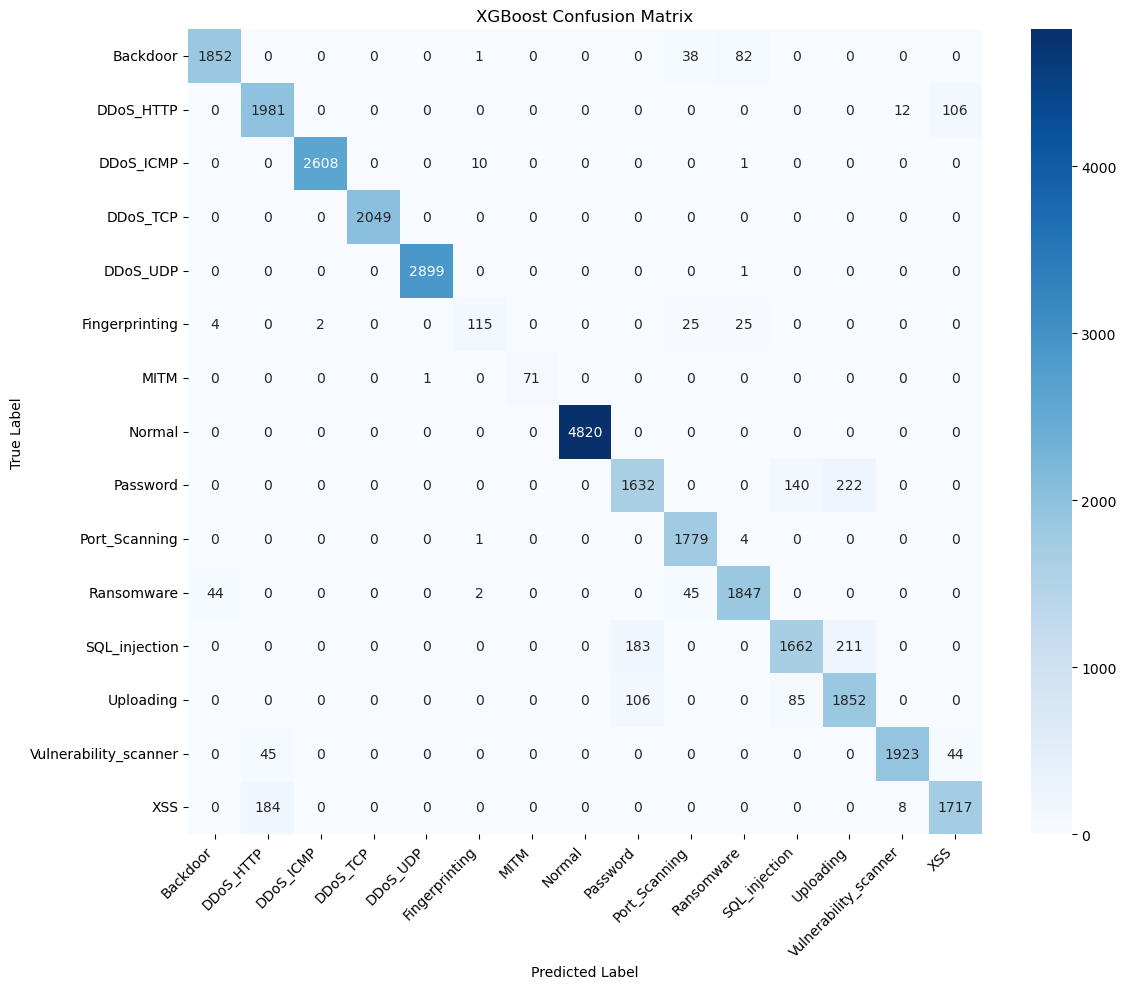


Training CatBoost...


KeyboardInterrupt: 

In [11]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

models_baseline = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0, thread_count=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    
}

results_baseline = evaluate_models(models_baseline, X_train, y_train, X_val, y_val, labels_ml)

# Ensemble Classifiers
Questions to answer:
1. Does combining our existing models in an ensemble improve performance?
2. Stacking or voting?
3. If stacking, which model performs the best as a final estimator?


Training Voting Ensemble...

Voting Ensemble Validation Set Results:
  Accuracy:         0.9449
  Precision Macro:  0.9394
  Precision Weight: 0.9453
  Recall Macro:     0.9255
  Recall Weight:    0.9449
  F1 Macro:         0.9312
  F1 Weight:        0.9448

Voting Ensemble Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96      1973
            DDoS_HTTP       0.90      0.94      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.91      0.69      0.79       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00      4820
             Password       0.82      0.83      0.82      1994
        Port_Scanning       0.94      1.00      0.97      1784
       

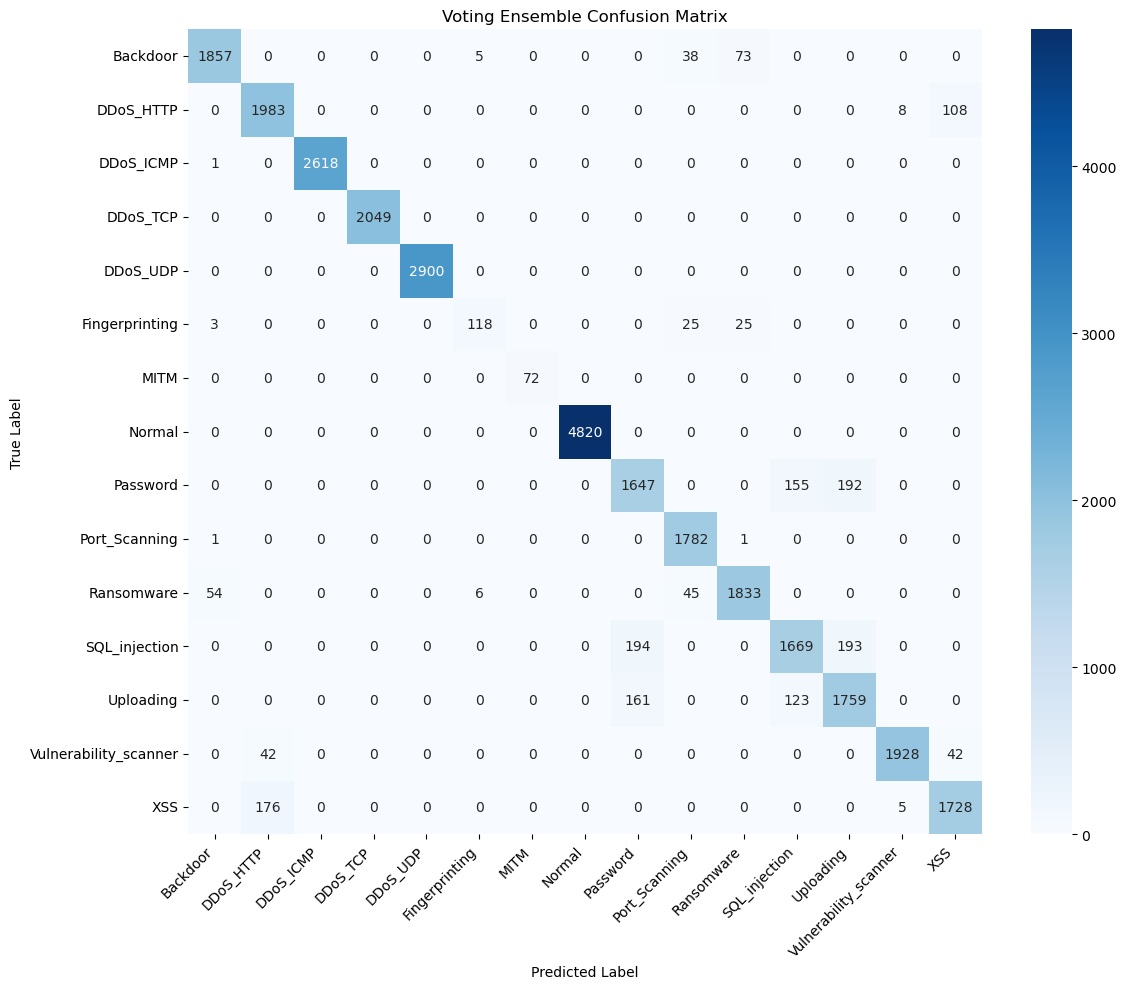


Training Stacking Ensemble (XGB)...

Stacking Ensemble (XGB) Validation Set Results:
  Accuracy:         0.9444
  Precision Macro:  0.9436
  Precision Weight: 0.9458
  Recall Macro:     0.9240
  Recall Weight:    0.9444
  F1 Macro:         0.9315
  F1 Weight:        0.9443

Stacking Ensemble (XGB) Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.95      1973
            DDoS_HTTP       0.89      0.95      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.98      0.69      0.81       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.87      0.80      0.83      1994
        Port_Scanning       0.94      1.00    

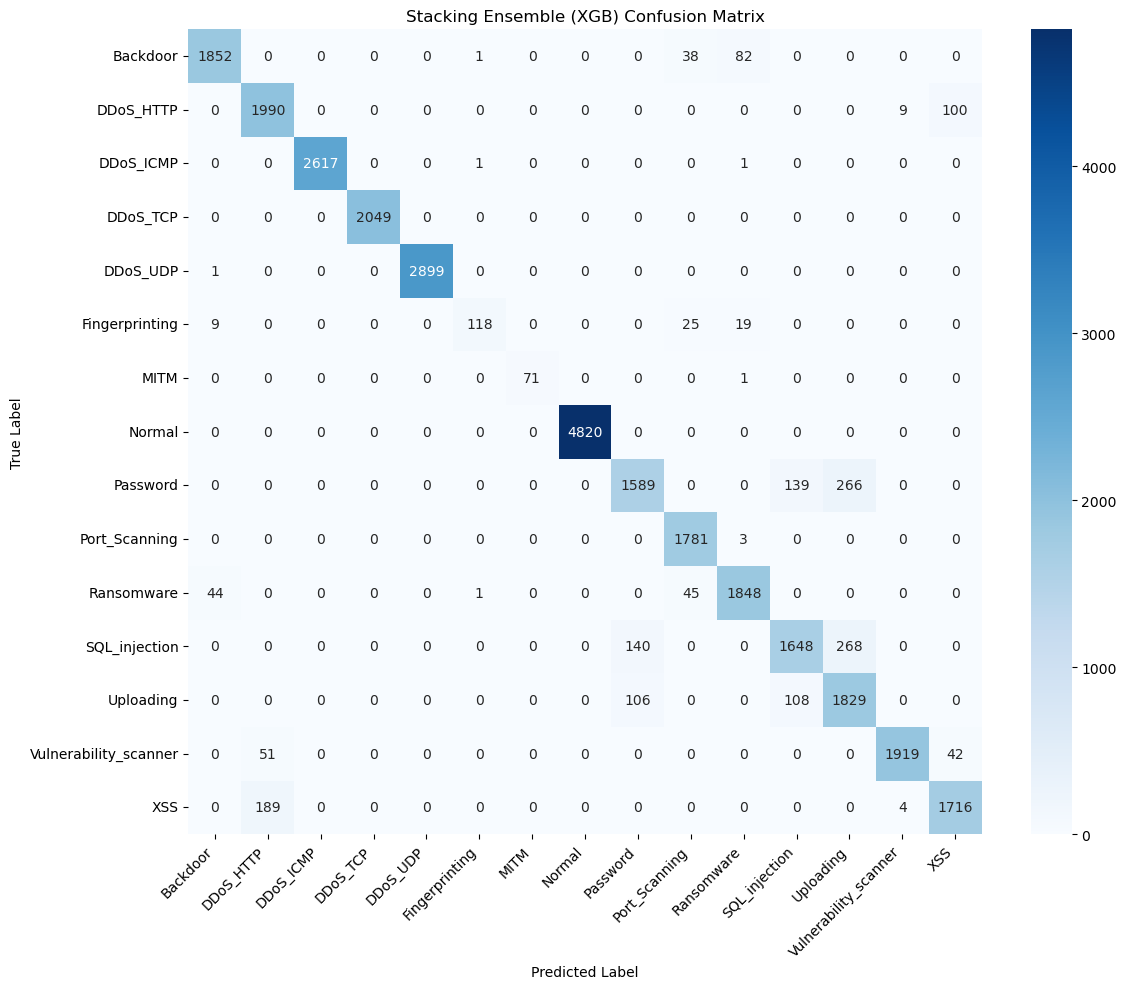


EVALUATION COMPLETE


In [6]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

voting_model = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)),
        # ('cat', CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)), NOTE: errors with sklearn tags in ensemble, temporarily removed
        ('lgbm', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ],
    voting='soft'
)

stacking_model_xgb = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)),
        # ('cat', CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)), NOTE: errors with sklearn tags in ensemble, temporarily removed
        ('lgbm', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ],
    final_estimator=XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)
)

models_ensemble = {
    "Voting Ensemble": voting_model,
    "Stacking Ensemble (XGB)": stacking_model_xgb
}

results_ensemble = evaluate_models(models_ensemble, X_train, y_train, X_val, y_val, labels_ml)

# Results:
**CatBoost** appears as the best performing model, although hard to tell due to the fact I cannot get catboost to work in sklearn ensemble classifiers.

Across the board, it seems like the worst performing class is **Fingerprinting**, next steps likely involve adjusting preprocessing to improve performance in that class.

# Investigating Fingerprinting Predictions

`Fingerprinting` is getting misclassified as `Port_Scanning` or `Ransomware` by all models.

Plotting UMAP of all classes to see if this is an issue with seperability

### UMAP Clusters

In [ ]:
!pip install umap-learn

/opt/anaconda3/envs/cyber_env/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/cyber_env/lib/python3.14/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/var/folders/w0/phbd_c51633d1cf8bvb7606r0000gn/T/ipykernel_31101/332294322.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(classes))


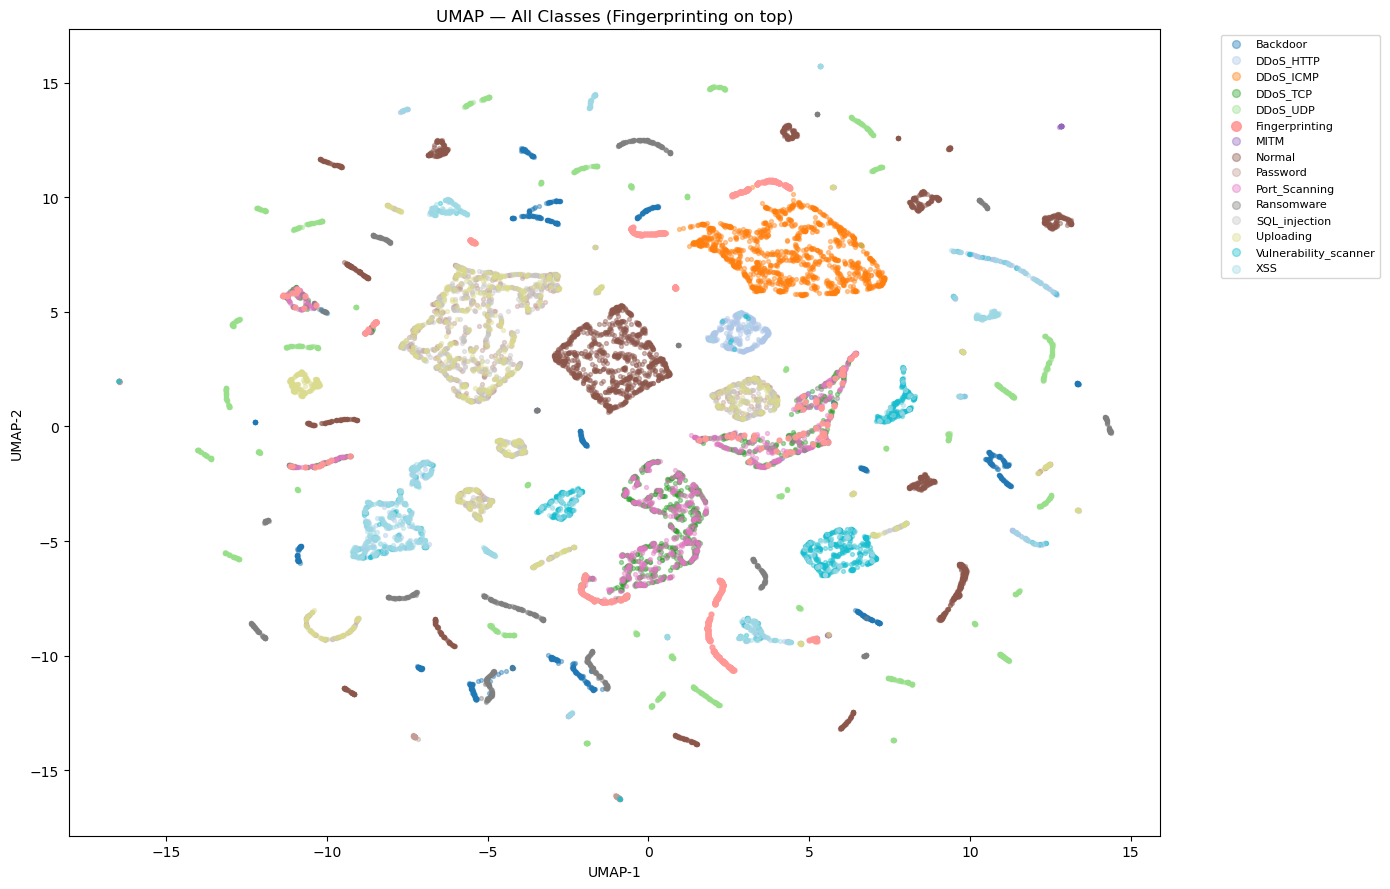

In [15]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

y_train_decoded = y_train.map({int(k): v for k, v in labels_ml.items()})

target_class = 'Fingerprinting'

fp_mask = y_train_decoded == target_class
X_fp = X_train[fp_mask]
y_fp = y_train_decoded[fp_mask]

n_other = min(15000, (~fp_mask).sum())
X_other = X_train[~fp_mask].sample(n=n_other, random_state=42)
y_other = y_train_decoded[~fp_mask].sample(n=n_other, random_state=42)

X_sample = pd.concat([X_fp, X_other])
y_sample = pd.concat([y_fp, y_other])

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sample)

X_vis, y_vis = X_umap, y_sample.values

# Assign a distinct color to each class
classes = np.unique(y_vis)
cmap = plt.cm.get_cmap('tab20', len(classes))
color_map = {cls: cmap(i) for i, cls in enumerate(classes)}

fig, ax = plt.subplots(figsize=(14, 9))

# Plot all classes including Fingerprinting with consistent styling
for cls in classes:
    mask = y_vis == cls
    zorder = 5 if cls == target_class else 1
    size = 12 if cls == target_class else 8
    alpha = 0.9 if cls == target_class else 0.4
    ax.scatter(
        X_vis[mask, 0], X_vis[mask, 1],
        color=color_map[cls], alpha=alpha, s=size,
        label=cls, zorder=zorder
    )

ax.set_title('UMAP — All Classes (Fingerprinting on top)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, markerscale=2)
plt.tight_layout()
plt.show()

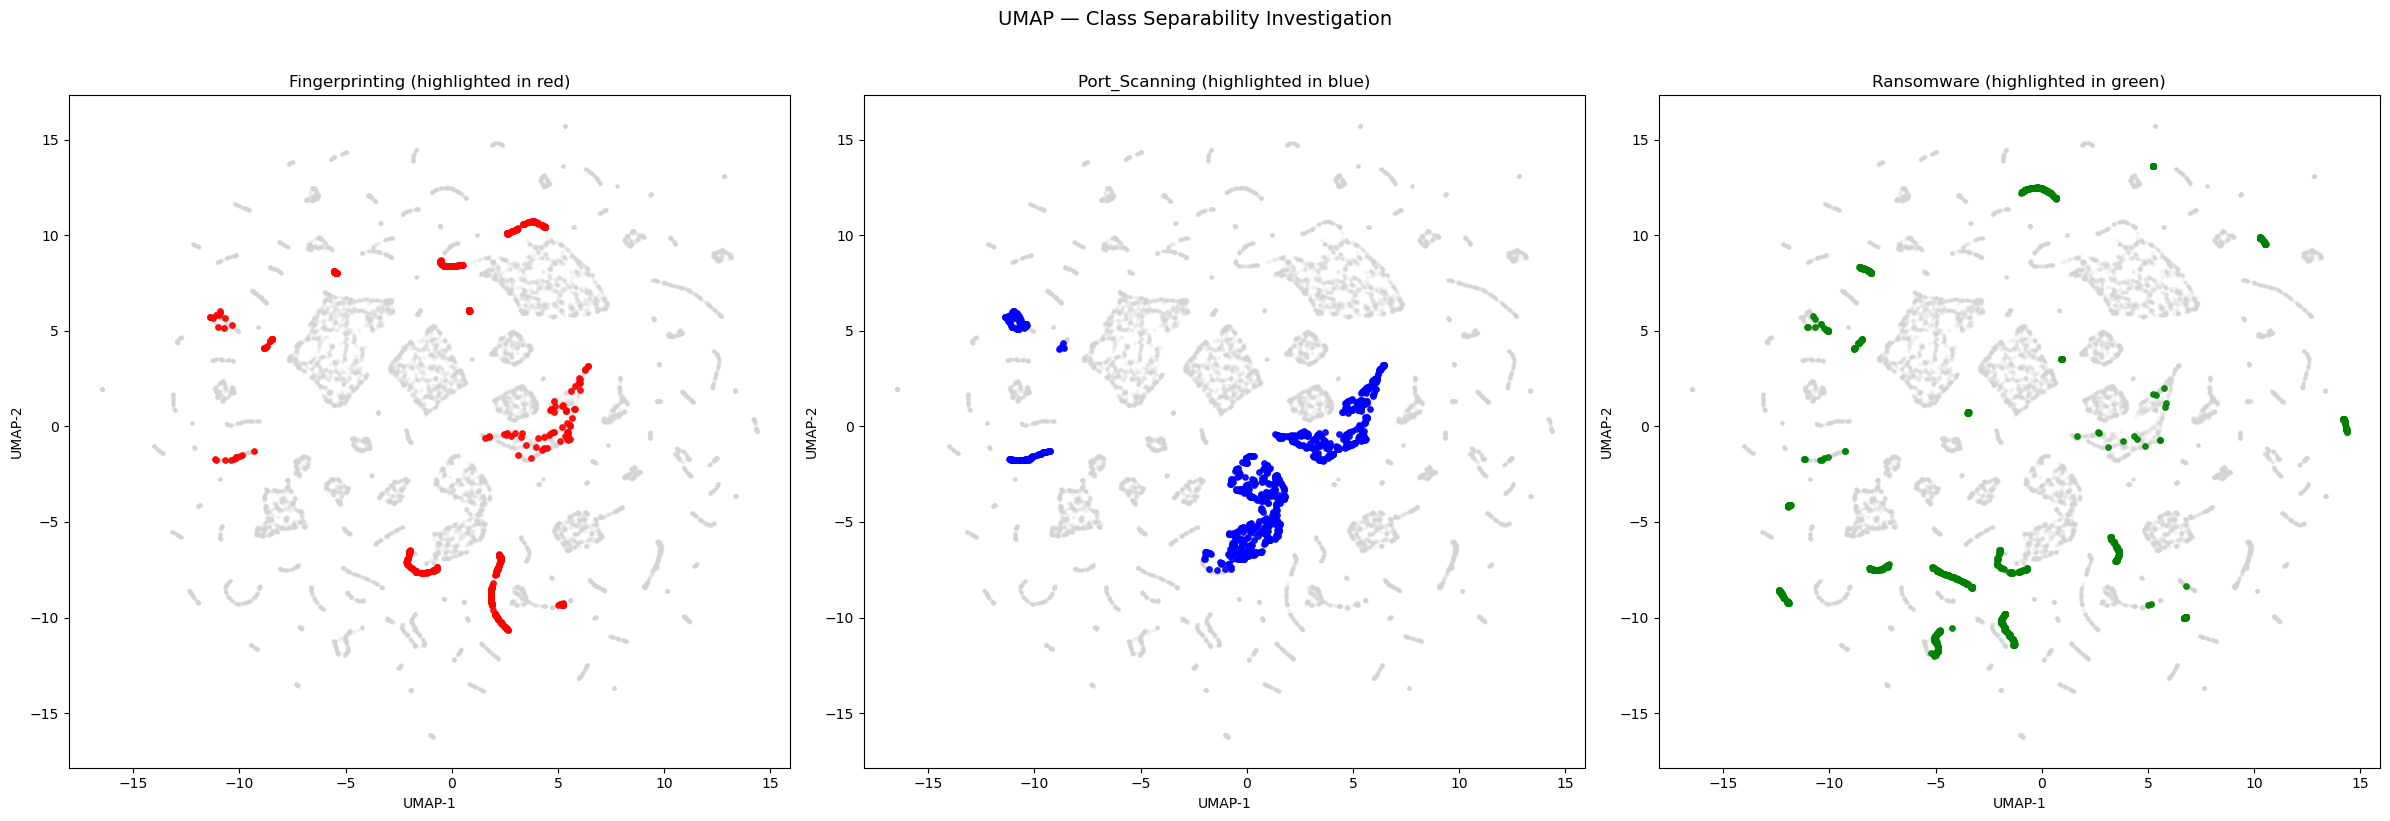

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

hardcoded_colors = {
    'Fingerprinting': 'red',
    'Port_Scanning': 'blue',
    'Ransomware': 'green'
}

for ax, (focus_class, focus_color) in zip(axes, hardcoded_colors.items()):
    for cls in classes:
        mask = y_vis == cls
        is_focus = cls == focus_class
        ax.scatter(
            X_vis[mask, 0], X_vis[mask, 1],
            color=focus_color if is_focus else 'lightgrey',
            alpha=0.9 if is_focus else 0.2,
            s=15 if is_focus else 4,
            label=cls if is_focus else None,
            zorder=5 if is_focus else 1
        )
    ax.set_title(f'{focus_class} (highlighted in {focus_color})')
    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')

plt.suptitle('UMAP — Class Separability Investigation', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### UMAP Findings
From the above plots, it's clear why `Fingerprinting` is getting misclassified, as the large majority of the `Fingerprinting` UMAP clusters overlap with `Port_Scanning` and `Ransomware`

Fixing this will likely require feature engineering

### Feature Importance

As `Catboost` performed the best on `Fingerprinting`, will use `Catboost` model to investigate which features prominently denote `Fingerprinting` vs. the other classes it overlaps with.

In [6]:
# Which features does the best performing model on Fingerprinting care the most about?
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
cat.fit(X_train, y_train)

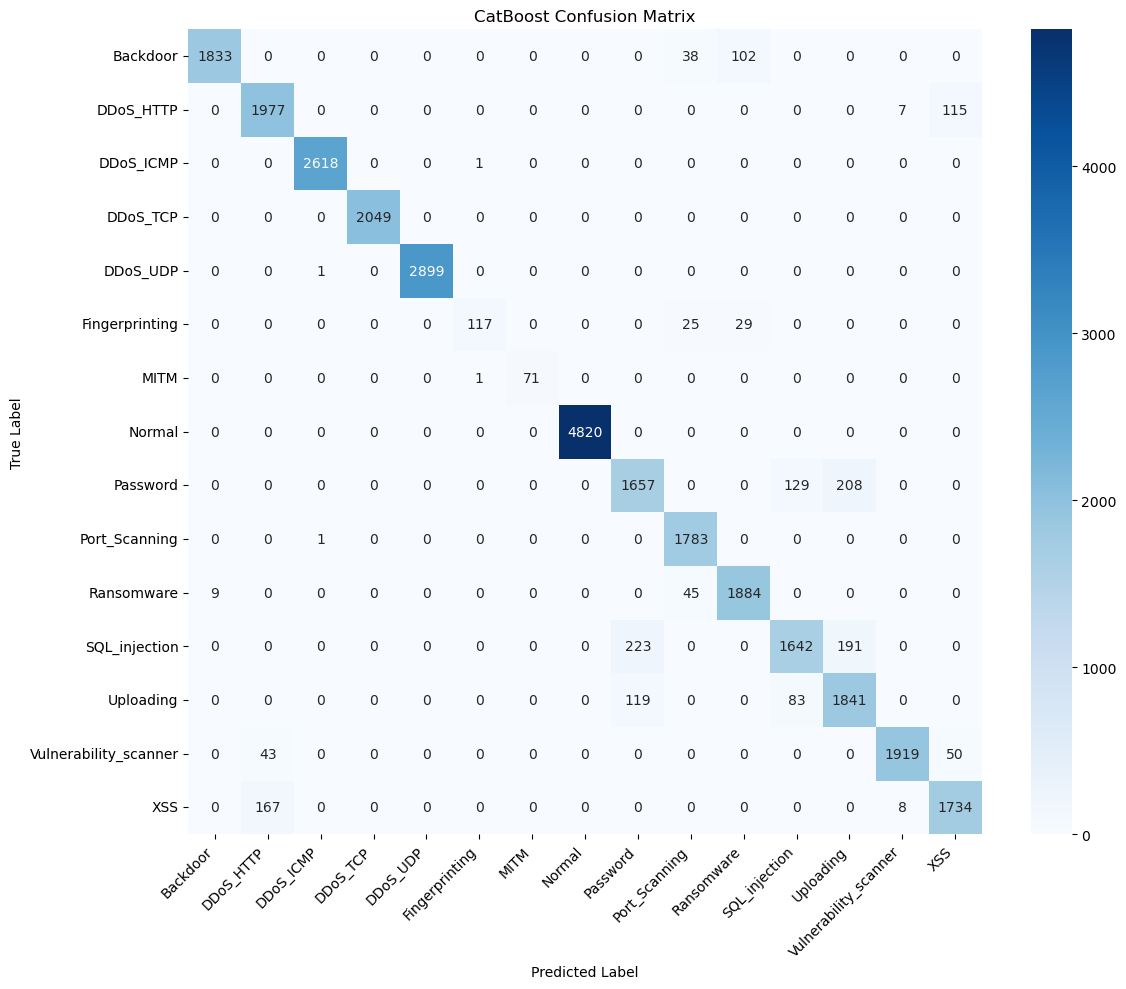

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = cat.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
target_names = [labels_ml[i] for i in sorted(labels_ml.keys())]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'CatBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
import shap
explainer = shap.TreeExplainer(cat)

fingerprint_label = [key for key, value in labels_ml.items() if value == 'Fingerprinting'][0]
shap_values = explainer.shap_values(X_val[y_val == fingerprint_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, fingerprint_label]
else:
    sv = shap_values[fingerprint_label]

shap.summary_plot(sv, 
                  X_val[y_val == fingerprint_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")

NameError: name 'cat' is not defined

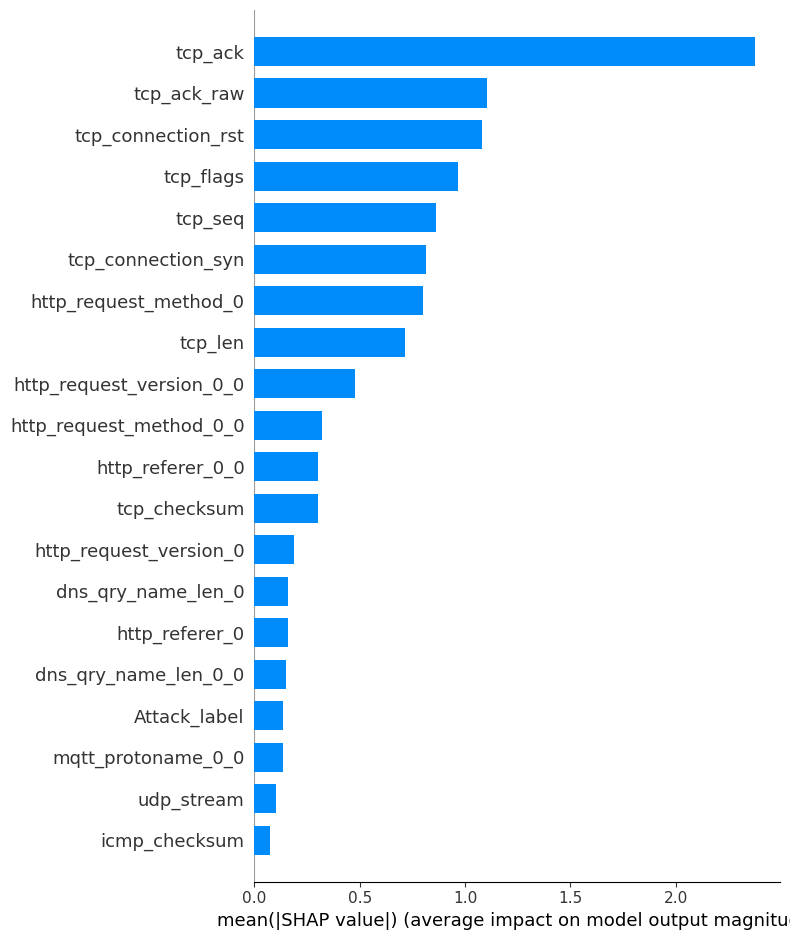

In [ ]:
port_scanning_label = [key for key, value in labels_ml.items() if value == 'Port_Scanning'][0]
shap_values = explainer.shap_values(X_val[y_val == port_scanning_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, port_scanning_label]
else:
    sv = shap_values[port_scanning_label]

shap.summary_plot(sv, 
                  X_val[y_val == port_scanning_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")

In [ ]:
ransomware_label = [key for key, value in labels_ml.items() if value == 'Ransomware'][0]
shap_values = explainer.shap_values(X_val[y_val == ransomware_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, ransomware_label]
else:
    sv = shap_values[ransomware_label]

shap.summary_plot(sv, 
                  X_val[y_val == ransomware_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")

### SHAP Plot Findings:
All classes seem to have `tcp_ack` and `tcp_ack_raw` as highly significant features, likely contributing to the overlap

For `Fingerprinting`, most signfificant features are `icmp_checksum` and `icmp_seq_le`.


**Ideas:**
- Create interaction features between `icmp_checksum` and `icmp_seq_le`
- Shared TCP features are likely causing the overap, engineer `Fingerprinting`-specific feature capturing combination of ICMP and TCP patterns
- Train specialist one-vs-rest binary classifier for `Fingerprinting` using only ICMP features and a few TCP ones, ensemble it with Catboost

#### Part 1: Feature Engineering

Engineer features to capture ICMP + TCP interactions t help boost 

In [5]:
def engineer_features(df):
    """
    Engineer features to boost Fingerprinting class separability.
    Operates on preprocessed/scaled dataframe, adds new columns in-place.
    Based on SHAP analysis: ICMP features are unique to Fingerprinting,
    TCP features are the source of confusion with Port_Scanning/Ransomware.
    """
    df = df.copy()

    # --- ICMP interaction features (Fingerprinting's unique signal) ---
    # SHAP showed icmp_checksum + icmp_seq_le are top Fingerprinting features
    df['icmp_checksum_x_seq'] = df['icmp_checksum'] * df['icmp_seq_le']
    df['icmp_checksum_sq'] = df['icmp_checksum'] ** 2
    df['icmp_seq_sq'] = df['icmp_seq_le'] ** 2
    df['icmp_ratio'] = df['icmp_checksum'] / (df['icmp_seq_le'] + 1e-9)

    # --- ICMP vs TCP contrast features ---
    # Fingerprinting uses ICMP probes alongside TCP, others use mostly TCP
    df['icmp_tcp_ack_ratio'] = df['icmp_checksum'] / (df['tcp_ack'] + 1e-9)
    df['icmp_tcp_seq_ratio'] = df['icmp_seq_le'] / (df['tcp_seq'] + 1e-9)
    df['icmp_vs_tcp_len'] = df['icmp_checksum'] - df['tcp_len']
    df['icmp_checksum_x_tcp_flags'] = df['icmp_checksum'] * df['tcp_flags']

    # --- TCP probe pattern features (distinguish from Port_Scanning/Ransomware) ---
    # Port_Scanning: high tcp_connection_rst, tcp_flags variation
    # Ransomware: high tcp_seq, http features
    # Fingerprinting: lower tcp_connection_rst but mixed tcp_flags
    df['tcp_ack_x_flags'] = df['tcp_ack'] * df['tcp_flags']
    df['tcp_seq_x_len'] = df['tcp_seq'] * df['tcp_len']
    df['tcp_ack_seq_ratio'] = df['tcp_ack'] / (df['tcp_seq'] + 1e-9)
    df['tcp_ack_x_rst'] = df['tcp_ack'] * df['tcp_connection_rst']
    df['tcp_syn_rst_ratio'] = df['tcp_connection_syn'] / (df['tcp_connection_rst'] + 1e-9)

    # --- ICMP + TCP combined probe signature ---
    # nmap/fingerprinting tools send both ICMP + TCP probes simultaneously
    # this combo should be rare in Port_Scanning (TCP only) and Ransomware (HTTP/TCP)
    df['icmp_tcp_probe_score'] = (
        df['icmp_checksum'] * df['icmp_seq_le'] * df['tcp_flags']
    )
    df['icmp_present_x_tcp_ack'] = (
        (df['icmp_checksum'] > 0).astype(int) * df['tcp_ack']
    )

    print(f"Added {len([c for c in df.columns if c not in df.columns])} new features")
    print(f"New columns: {[c for c in df.columns if '_x_' in c or '_ratio' in c or '_sq' in c or '_score' in c]}")

    return df

Added 0 new features
New columns: ['icmp_checksum_x_seq', 'icmp_checksum_sq', 'icmp_seq_sq', 'icmp_ratio', 'icmp_tcp_ack_ratio', 'icmp_tcp_seq_ratio', 'icmp_checksum_x_tcp_flags', 'tcp_ack_x_flags', 'tcp_seq_x_len', 'tcp_ack_seq_ratio', 'tcp_ack_x_rst', 'tcp_syn_rst_ratio', 'icmp_tcp_probe_score', 'icmp_present_x_tcp_ack']
Added 0 new features
New columns: ['icmp_checksum_x_seq', 'icmp_checksum_sq', 'icmp_seq_sq', 'icmp_ratio', 'icmp_tcp_ack_ratio', 'icmp_tcp_seq_ratio', 'icmp_checksum_x_tcp_flags', 'tcp_ack_x_flags', 'tcp_seq_x_len', 'tcp_ack_seq_ratio', 'tcp_ack_x_rst', 'tcp_syn_rst_ratio', 'icmp_tcp_probe_score', 'icmp_present_x_tcp_ack']
Added 0 new features
New columns: ['icmp_checksum_x_seq', 'icmp_checksum_sq', 'icmp_seq_sq', 'icmp_ratio', 'icmp_tcp_ack_ratio', 'icmp_tcp_seq_ratio', 'icmp_checksum_x_tcp_flags', 'tcp_ack_x_flags', 'tcp_seq_x_len', 'tcp_ack_seq_ratio', 'tcp_ack_x_rst', 'tcp_syn_rst_ratio', 'icmp_tcp_probe_score', 'icmp_present_x_tcp_ack']

Training XGBoost...

XGB

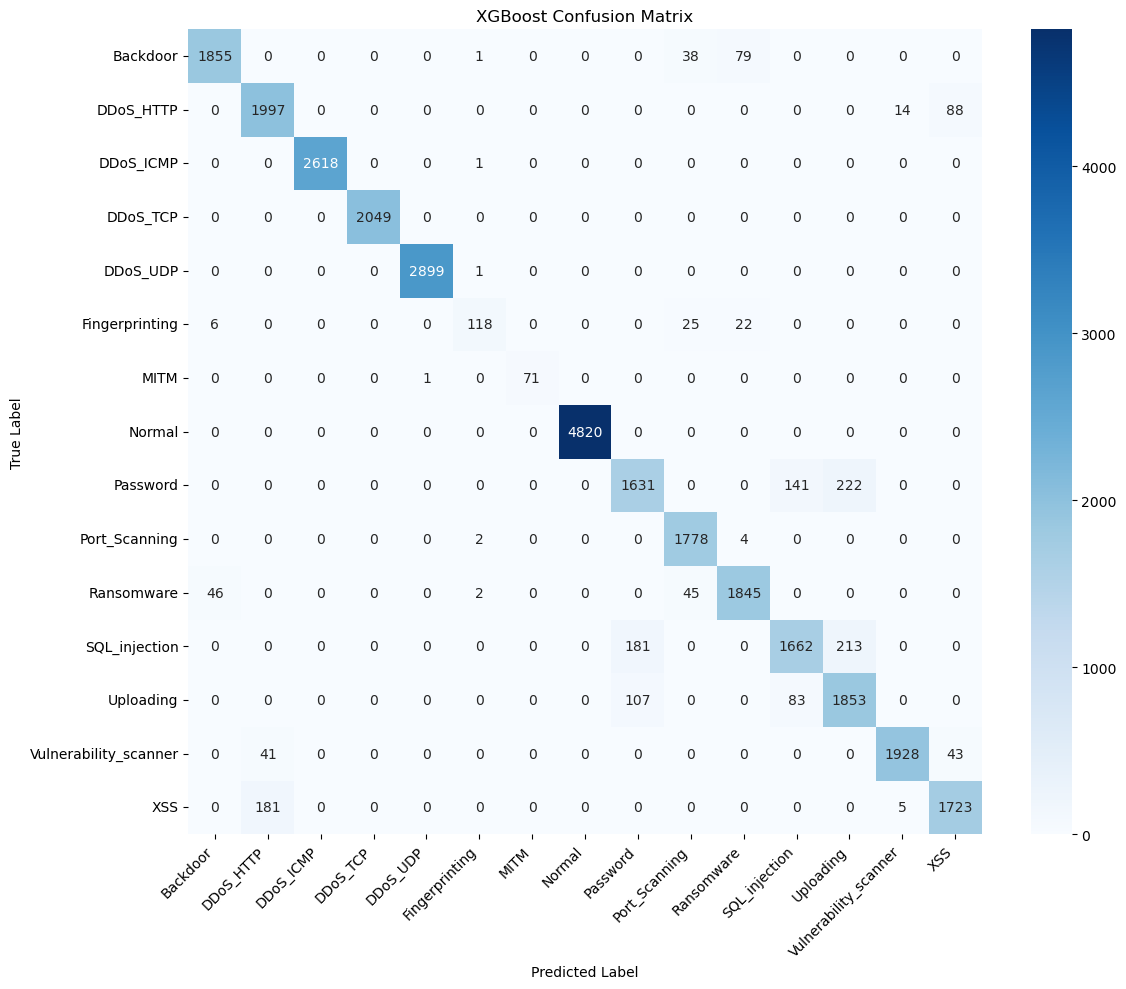


Training CatBoost...

CatBoost Validation Set Results:
  Accuracy:         0.9477
  Precision Macro:  0.9474
  Precision Weight: 0.9486
  Recall Macro:     0.9271
  Recall Weight:    0.9477
  F1 Macro:         0.9349
  F1 Weight:        0.9476

CatBoost Classification Report:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.93      0.96      1973
            DDoS_HTTP       0.91      0.94      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.99      0.68      0.81       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.83      0.83      0.83      1994
        Port_Scanning       0.94      1.00      0.97      1784
           Ransomware       

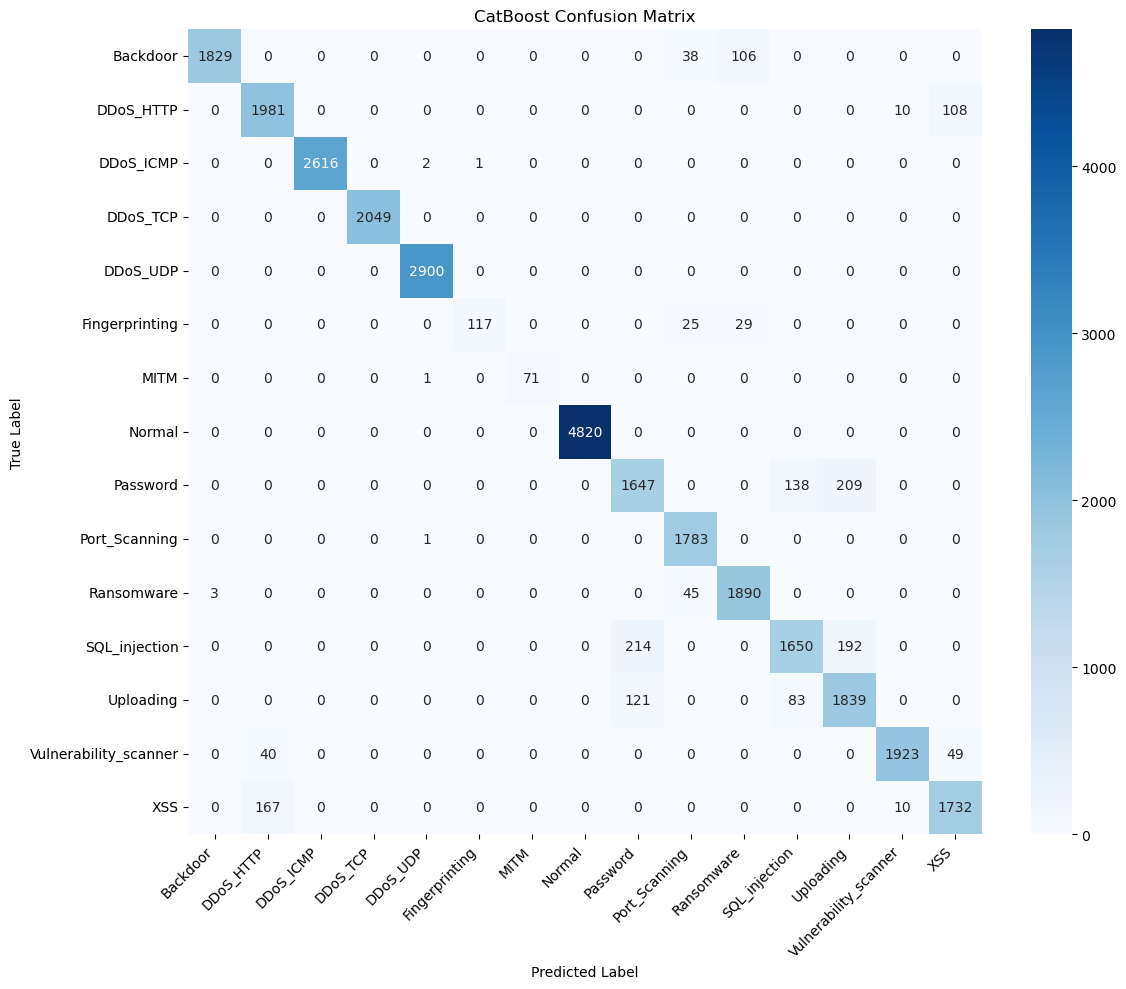


Training LightGBM...

LightGBM Validation Set Results:
  Accuracy:         0.9464
  Precision Macro:  0.9362
  Precision Weight: 0.9472
  Recall Macro:     0.9260
  Recall Weight:    0.9464
  F1 Macro:         0.9302
  F1 Weight:        0.9463

LightGBM Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96      1973
            DDoS_HTTP       0.90      0.95      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.83      0.69      0.75       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.85      0.81      0.83      1994
        Port_Scanning       0.94      0.99      0.97      1784
           Ransomware       

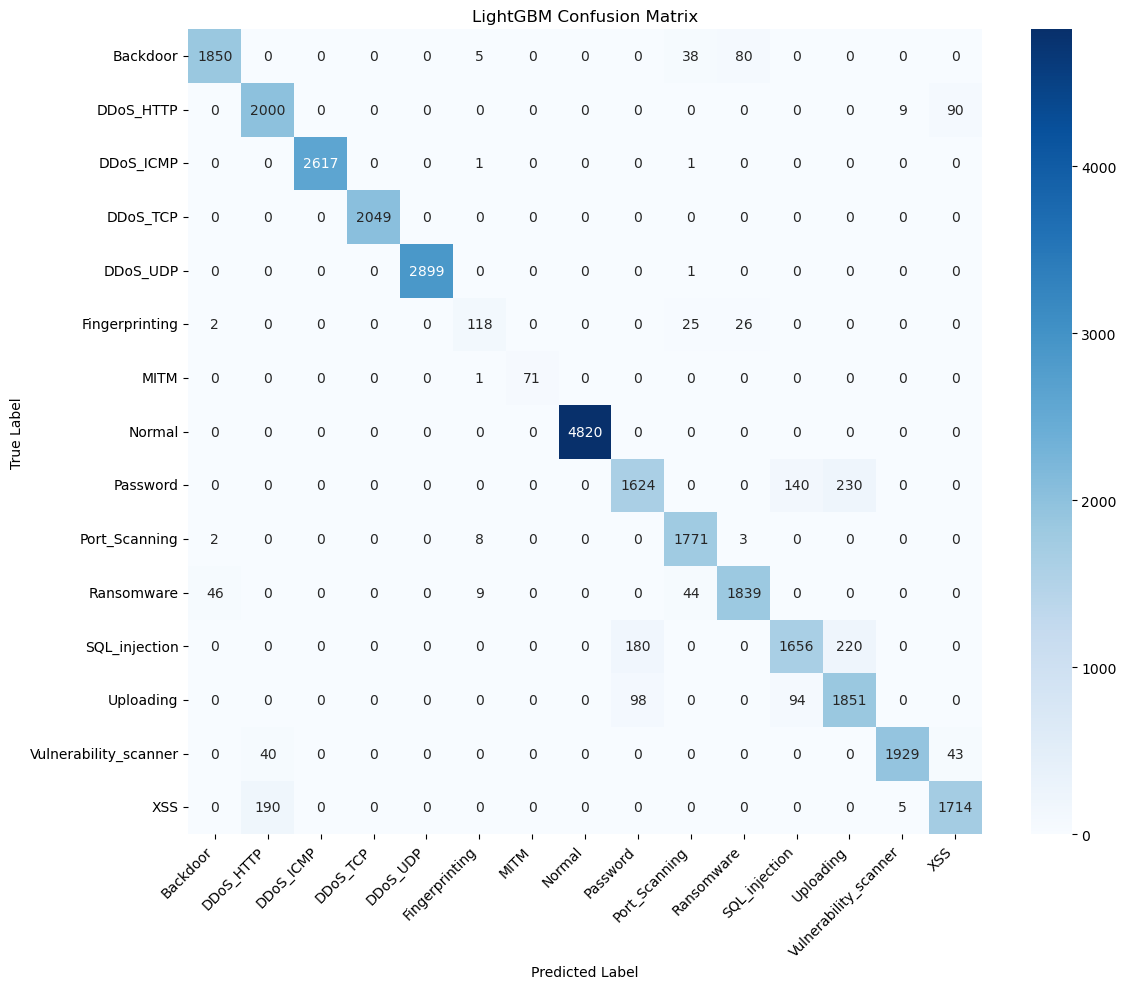


Training RandomForest...

RandomForest Validation Set Results:
  Accuracy:         0.9376
  Precision Macro:  0.9244
  Precision Weight: 0.9379
  Recall Macro:     0.9191
  Recall Weight:    0.9376
  F1 Macro:         0.9214
  F1 Weight:        0.9376

RandomForest Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.96      0.94      0.95      1973
            DDoS_HTTP       0.91      0.87      0.89      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.79      0.70      0.75       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00      4820
             Password       0.81      0.83      0.82      1994
        Port_Scanning       0.94      1.00      0.97      1784
           Ranso

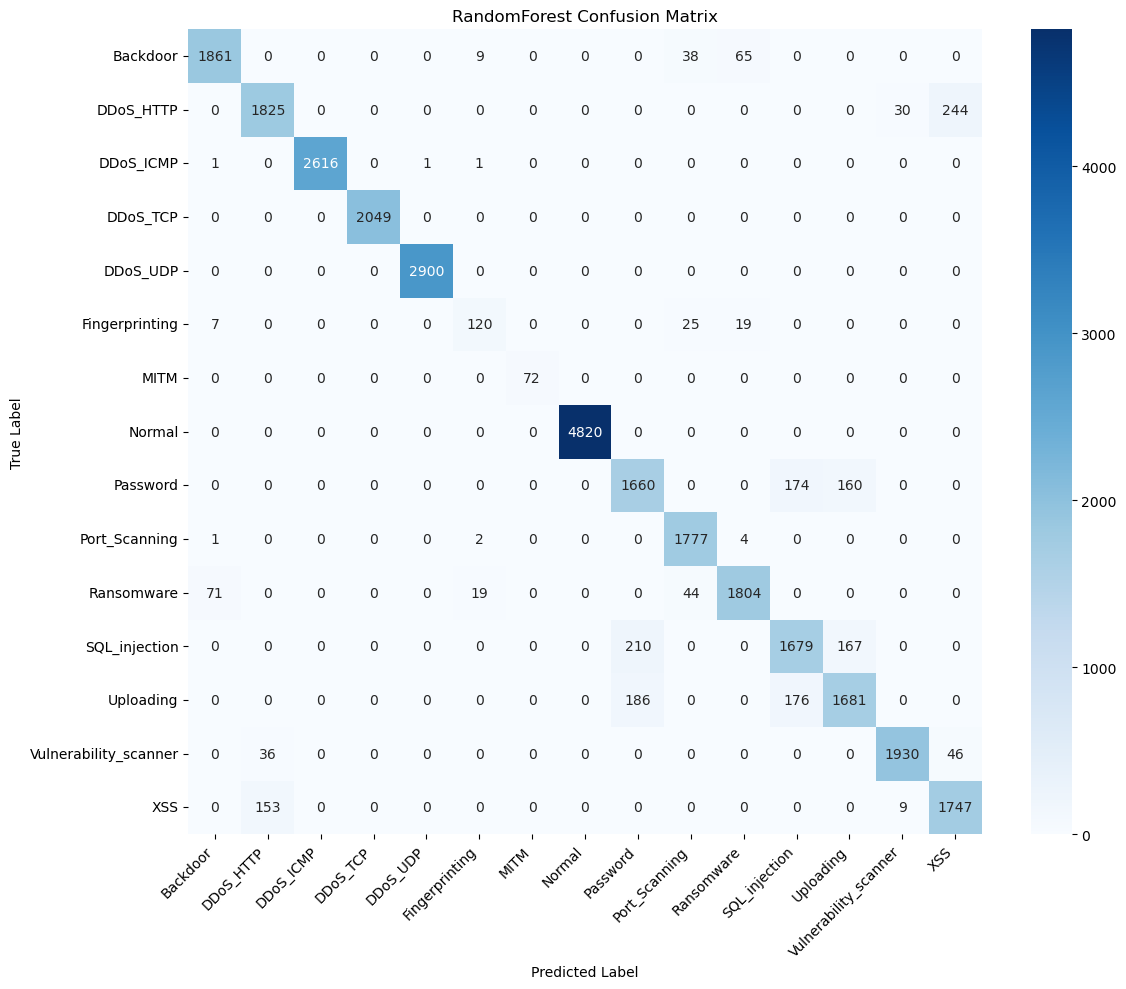


EVALUATION COMPLETE


{'XGBoost': {'y_pred': array([11, 14,  2, ...,  9,  0, 10], shape=(30439,)),
  'confusion_matrix': array([[1855,    0,    0,    0,    0,    1,    0,    0,    0,   38,   79,
             0,    0,    0,    0],
         [   0, 1997,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,   14,   88],
         [   0,    0, 2618,    0,    0,    1,    0,    0,    0,    0,    0,
             0,    0,    0,    0],
         [   0,    0,    0, 2049,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0],
         [   0,    0,    0,    0, 2899,    1,    0,    0,    0,    0,    0,
             0,    0,    0,    0],
         [   6,    0,    0,    0,    0,  118,    0,    0,    0,   25,   22,
             0,    0,    0,    0],
         [   0,    0,    0,    0,    1,    0,   71,    0,    0,    0,    0,
             0,    0,    0,    0],
         [   0,    0,    0,    0,    0,    0,    0, 4820,    0,    0,    0,
             0,    0,    0,    0],
         [   0,

In [19]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

X_train_eng = engineer_features(X_train)
X_val_eng   = engineer_features(X_val)
X_test_eng  = engineer_features(X_test)

models_feat_eng = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0, thread_count=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
}

evaluate_models(models_feat_eng, X_train_eng, y_train, X_val_eng, y_val, labels_ml)

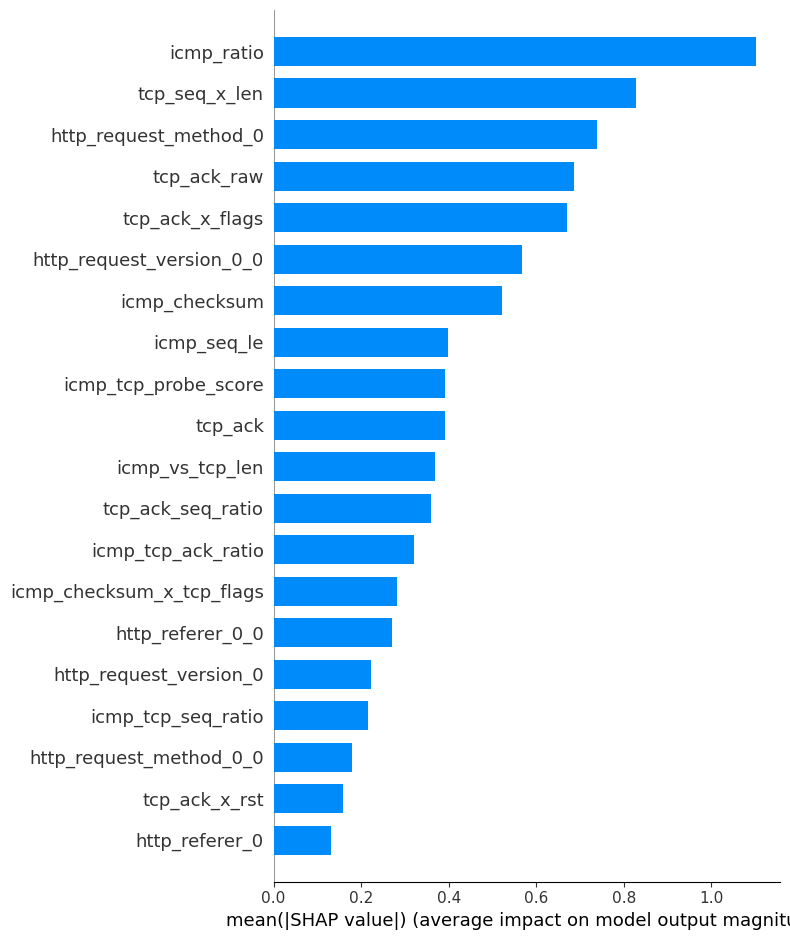

In [21]:
import shap
explainer = shap.TreeExplainer(models_feat_eng['CatBoost'])

fingerprint_label = [key for key, value in labels_ml.items() if value == 'Fingerprinting'][0]
shap_values = explainer.shap_values(X_val_eng[y_val == fingerprint_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, fingerprint_label]
else:
    sv = shap_values[fingerprint_label]

shap.summary_plot(sv, 
                  X_val_eng[y_val == fingerprint_label], 
                  feature_names=X_train_eng.columns,
                  plot_type="bar")

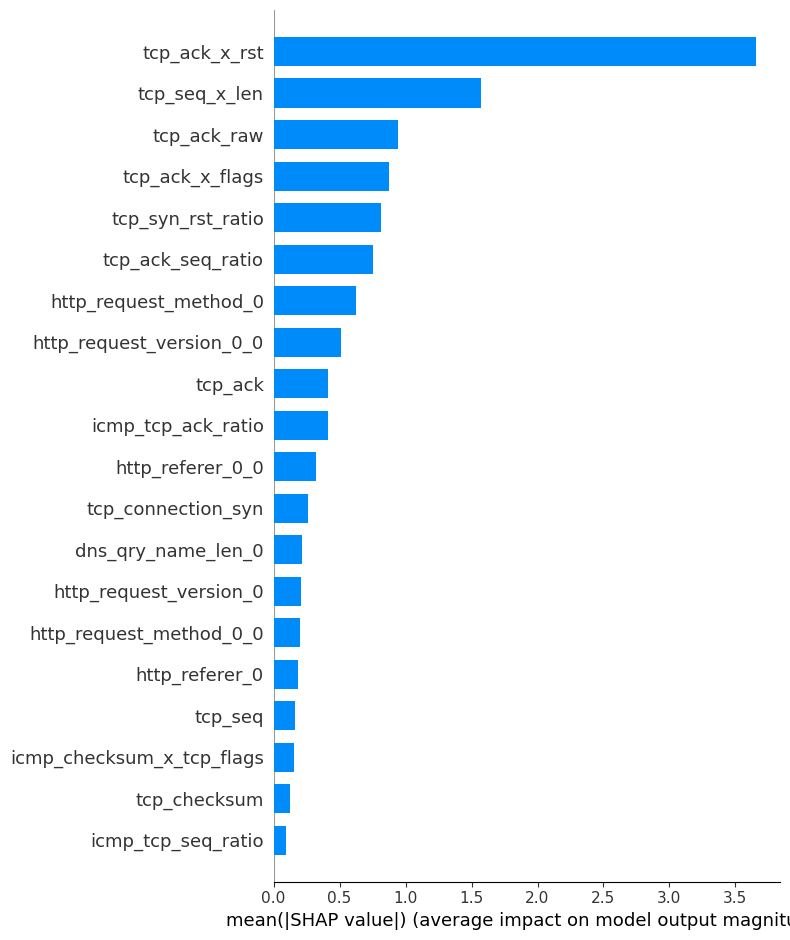

In [23]:
port_scanning_label = [key for key, value in labels_ml.items() if value == 'Port_Scanning'][0]
shap_values = explainer.shap_values(X_val_eng[y_val == port_scanning_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, port_scanning_label]
else:
    sv = shap_values[port_scanning_label]

shap.summary_plot(sv, 
                  X_val_eng[y_val == port_scanning_label], 
                  feature_names=X_train_eng.columns,
                  plot_type="bar")

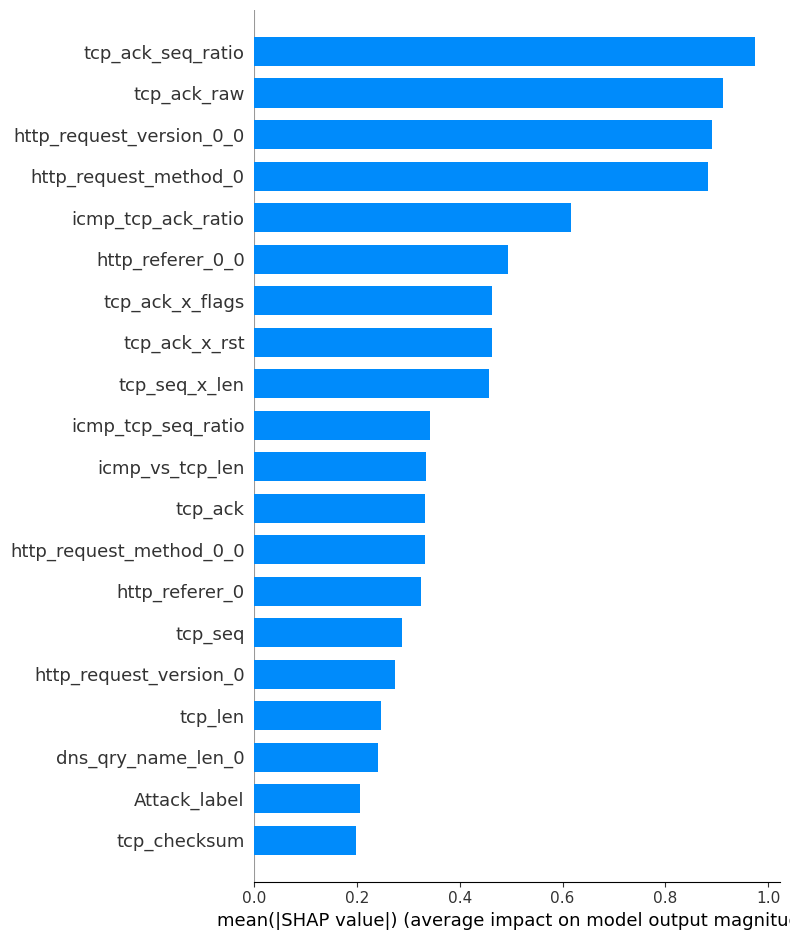

In [24]:
ransomware_label = [key for key, value in labels_ml.items() if value == 'Ransomware'][0]
shap_values = explainer.shap_values(X_val_eng[y_val == ransomware_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, ransomware_label]
else:
    sv = shap_values[ransomware_label]

shap.summary_plot(sv, 
                  X_val_eng[y_val == ransomware_label], 
                  feature_names=X_train_eng.columns,
                  plot_type="bar")

### Part 2: One-Vs-All Classifier